In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Gaussian process library ["GPy"]('https://sheffieldml.github.io/GPy/') used in this notebook:

In [2]:
import GPy as gpy

# Gaussian processes

A Gaussian process (GP) is an infinite-dimensional Gaussian distribution. A great Jupyter notebook by [Andreas Damianou](http://adamian.github.io/talks/Brown2016.html) (2016) gives an intuitive, step-by-step explanation of this.

Similar to how a (1D) Gaussian distribution has a mean $\mu$ and variance $\sigma^2$, a GP has a mean function $\mu(x)$ (which we set to $0$ here for simplicity), and a covariance function $C(x,x')$, also known as the *kernel*. Also, just as we can draw random samples from a Gaussian distributon, we can draw random samples (functions of $x$) from a GP. $C(x,x')$ tells us the correlation between the function's values at 2 inputs $x$ and $x'$, and (with the mean function) entirely determines the behaviour of the GP.

Below are samples from the most-commonly used kernel, the RBF (also known as the exponentiated quadratic or Gaussian), which is very smooth and has the form:
$$
k_{RBF}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \sum_{q=1}^Q (x_{i,q} - x_{j,q})^2\right)
$$
where $Q$ denotes the dimensionality of the input space. Its parameters are: the *lengthscale*, $\ell$ and the *variance* $\sigma^2$. For the rest of this notebook we consider only $Q=1$ for simplicity.

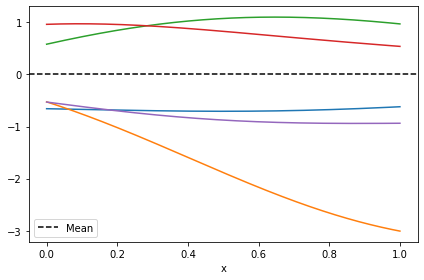

In [13]:
def createSamples(kernel):
    # Input space between 0 and 1
    numX = 1000
    X = np.linspace(0., 1., numX)
    # X must be a 2D array
    X = np.atleast_2d(X).T

    # Mean
    mu = np.zeros((numX))
    # Covariance
    C = kernel.K(X, X)
    # 5 random samples from GP
    samples = np.random.multivariate_normal(mu, C, 5)
    
    return X, samples

# RBF kernel
kernel = gpy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
X, samples = createSamples(kernel)

fig, ax = plt.subplots(1, 1)
for sample in samples:
    ax.plot(X, sample)
ax.axhline(0., c='k', ls='--', label='Mean')
ax.set_xlabel('x')

ax.legend()
fig.tight_layout()

Below we can see the effect of changing the parameters of the kernel:

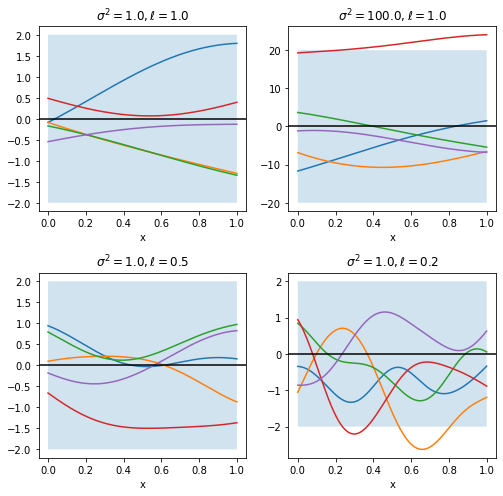

In [4]:
variances = [1., 100., 1., 1.]
lengthscales = [1., 1., 0.5, 0.2]

fig, axs = plt.subplots(2, 2, figsize=(7., 7.))
for ax, sigma2, l in zip(np.ravel(axs), variances, lengthscales):
    kernel = gpy.kern.RBF(input_dim=1, variance=sigma2, lengthscale=l)
    X, samples = createSamples(kernel)
    
    for sample in samples:
        ax.plot(X, sample)
    
    ax.fill_between(X.ravel(), -2.*np.sqrt(sigma2), 2.*np.sqrt(sigma2), alpha=0.2)
    ax.axhline(0., c='k')
    
    ax.set_title(fr'$\sigma^2 = {sigma2}, \ell = {l}$')
    ax.set_xlabel('x')

fig.tight_layout()

Decreasing $\ell$ makes the samples oscillate more rapidly, and increasing $\sigma^2$ by a factor of 100 gives samples that have a typical magnitude about 10x larger.

# GPs for regression

GPs can be used for regression if the data we are trying to fit have a Gaussian distribution (around the mean function $\mu$), and if the underlying process is smooth and continuous.

It is possible to constrain a GP at a number of inputs $x$, and perform the same sampling. The **GP mean** and **confidence intervals** give the mean and the spread of these samples. In other words, the confidence intervals are telling us the expected distribution of possible functions that pass through these points. Shown below are samples, the GP mean, and the confidence intervals, each for the same sets of kernel parameters.

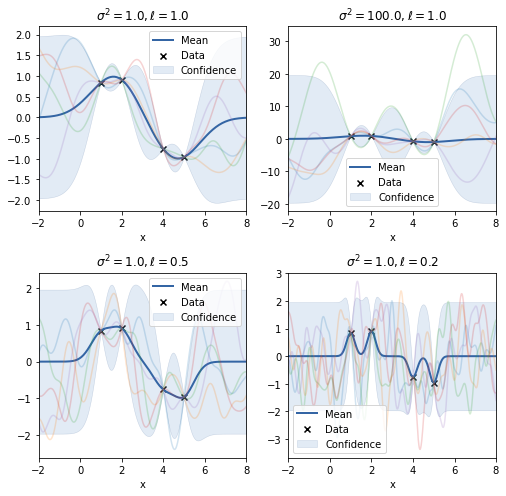

In [9]:
X_train = np.array([1., 2., 4., 5.]).reshape(-1, 1)
Y_train = np.sin(X_train)

fig, axs = plt.subplots(2, 2, figsize=(7., 7.))
for ax, sigma2, l in zip(np.ravel(axs), variances, lengthscales):
    kernel = gpy.kern.RBF(input_dim=1, variance=sigma2, lengthscale=l)
    GPModel = gpy.models.GPRegression(X_train, Y_train, kernel)
    GPModel.Gaussian_noise.variance.fix(0.)
    
    GPModel.plot(plot_limits=[-2, 8.], ax=ax)
    
    # Plot samples from "posterior"
    numSamples = 5
    XSample = np.linspace(-2., 8., 1000).reshape(-1, 1)
    posteriorSamples = GPModel.posterior_samples_f(XSample, full_cov=True, size=numSamples)
    for i in range(numSamples):
        ax.plot(XSample, posteriorSamples[:,:,i], alpha=0.2)
    
    ax.set_title(fr'$\sigma^2 = {sigma2}, \ell = {l}$')
    ax.set_xlabel('x')

fig.tight_layout()

The GP mean smoothly interpolates all training points. Outside the input domain, the GP mean approaches 0. For very low lengthscales, i.e. for $\ell=0.2$ in this case, the GP mean also approaches 0 in between training points. This occurs when the lengthscale is much smaller than the typical distance between training points. This corresponds to *overfitting* when fitting data.

In between training points, the confidence interval ($2\sigma$) grows, and it grows more when the lengthscale is small. At the edges of the input domain, the confidence intervals grow rapidly, demonstrating the uncertainty for extrapolation. At some point, they reach a maximum, $\approx 2\sigma$. In all cases, the confidence interval goes to 0 at each training point, and the GP mean passes straight through it.

GP regression can be extended to the case where the training points (i.e. data) have some uncertainty (e.g. experimental error), in which case the confidence intervals do not shrink all the way to 0, and the GP mean does not necessarily pass straight through them.

Clealy some sets of kernel parameters lead to better regression. The parameters can be optimised by maximising the likelihood (we do not give details here):

 /home/matt/anaconda3/envs/gp/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = 3.3839753215675086
Optimization restart 2/10, f = 3.383975321567508
Optimization restart 3/10, f = 3.38397532156751
Optimization restart 4/10, f = 3.383975321578529
Optimization restart 5/10, f = 3.3839753215675152
Optimization restart 6/10, f = 3.3839753215676582
Optimization restart 7/10, f = 3.3839753215734514
Optimization restart 8/10, f = 3.383975321567938
Optimization restart 9/10, f = 5.118429064140747
Optimization restart 10/10, f = 3.3839753215715285


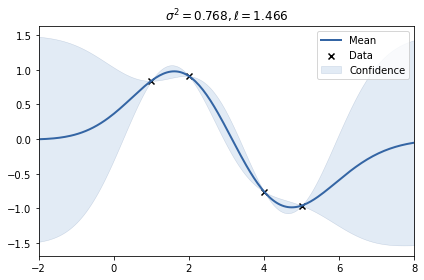

In [6]:
# Multiple restarts to optimization - likelihood surface often has multiple local maxima
GPModel.optimize_restarts()

# Obtain optimized kernel parameters
l = GPModel.rbf.lengthscale.values[0]
sigma2 = np.sqrt(GPModel.rbf.variance.values[0])

fig, ax = plt.subplots(1, 1)

GPModel.plot(plot_limits=[-2, 8.], ax=ax)
ax.set_title(fr'$\sigma^2 = {sigma2:.3f}, \ell = {l:.3f}$')
fig.tight_layout()

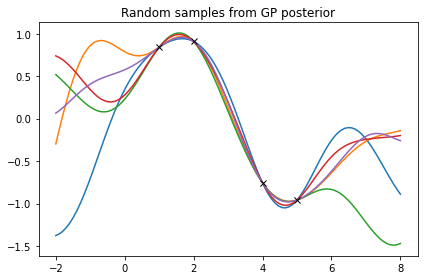

In [7]:
X = np.linspace(-2., 8., 100).reshape(-1, 1)
posteriorSamples = GPModel.posterior_samples_f(X, full_cov=True, size=5)

fig, ax = plt.subplots(1, 1)

for i in range(posteriorSamples.shape[2]):
    ax.plot(X, posteriorSamples[:,:,i])
ax.plot(X_train, Y_train, 'kx')
ax.set_title('Random samples from GP posterior')
fig.tight_layout()